<h1>Bissl Rumgeteste mit den Daten. Irrelevant für das Projekt, aber zu schade zum löschen</h1>

<h2>Setup</h2>

In [1]:
import pandas as pd
import streamlit as st
import sklearn as sk
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tsfresh
import pickle
import math
import os

2023-05-11 19:52:12.212 INFO    numba.cuda.cudadrv.driver: init


In [3]:
path = r"C:\Users\ReneJ\Desktop\Data"

<h2>Testsachen mit Lichtsensor und Bildschirmhelligkeit</h2>

In [117]:
#CSVs einlesen und DataFrames bauen. Weirde Spalten löschen und ne richtige Zeite Spalte hinzufügen

light = pd.read_csv(path+ r"\2023-04-22_08-09-30\Light.csv")
displayB = pd.read_csv(path + r"\2023-04-22_08-09-30\Brightness.csv")
battery = pd.read_csv(path + r"\2023-04-22_08-09-30\Battery.csv")
location = pd.read_csv(path + r"\2023-04-22_08-09-30\Location.csv")

dfs =[light, displayB, battery, location]

light["Time"] = pd.to_datetime(light['time'], unit = 'ns')
light.drop(columns=["time", "seconds_elapsed"])

displayB["Time"] = pd.to_datetime(displayB["time"], unit = 'ns')
displayB.drop(columns=["time", "seconds_elapsed"])

battery["Time"] = pd.to_datetime(battery['time'], unit = 'ns')
battery.drop(columns=["time", "seconds_elapsed"])

location["Time"] = pd.to_datetime(location['time'], unit = 'ns')
location.drop(columns=["time", "seconds_elapsed"])

type(location["Time"][0])
location["Time"][0].to_pydatetime()


for df in dfs:
    df["Readable_Time"] = df["Time"]
    for i in range(0,len(df["Time"])):
        df["Readable_Time"][i] = df["Time"][i].to_pydatetime()

light


C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: UserWarning: Discarding nonzero nanoseconds in conversion.
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\1473282944.py:29: SettingWithCopyWarning: 
A value is tryi

,time,seconds_elapsed,lux,Time,Readable_Time
0,1682150970343186200,-0.031814,361,2023-04-22 08:09:30.343186200,2023-04-22 08:09:30.343186
1,1682150970600927200,0.225927,361,2023-04-22 08:09:30.600927200,2023-04-22 08:09:30.600927
2,1682150970721837800,0.346838,363,2023-04-22 08:09:30.721837800,2023-04-22 08:09:30.721837
3,1682150970782262800,0.407263,365,2023-04-22 08:09:30.782262800,2023-04-22 08:09:30.782262
4,1682150970842687500,0.467687,363,2023-04-22 08:09:30.842687500,2023-04-22 08:09:30.842687
...,...,...,...,...,...
130200,1682205732018796500,54761.643797,9,2023-04-22 23:22:12.018796500,2023-04-22 23:22:12.018796
130201,1682205732200101600,54761.825102,6,2023-04-22 23:22:12.200101600,2023-04-22 23:22:12.200101
130202,1682205732639890400,54762.264890,9,2023-04-22 23:22:12.639890400,2023-04-22 23:22:12.639890
130203,1682205732821958100,54762.446958,11,2023-04-22 23:22:12.821958100,2023-04-22 23:22:12.821958


<Axes: xlabel='Time'>

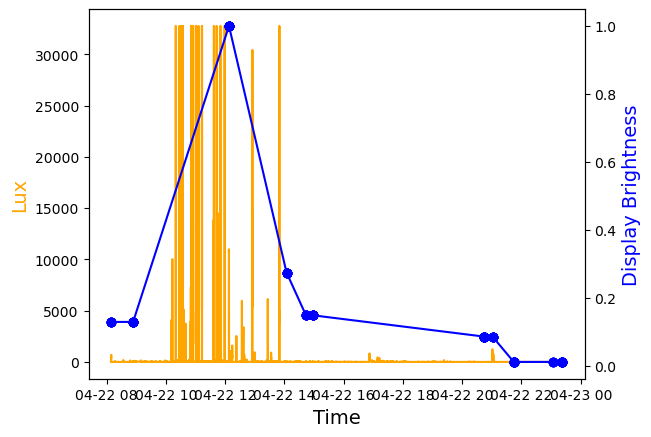

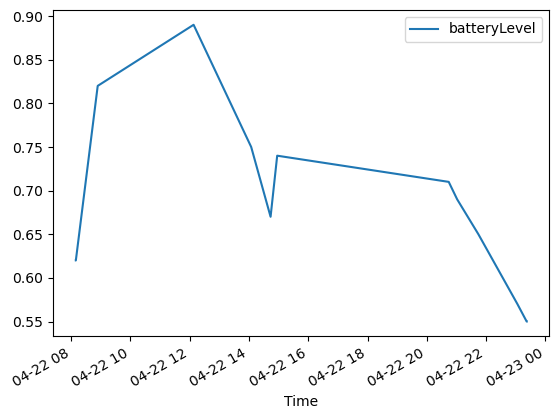

In [118]:
#light.plot(x= "Time", y = "lux")
#displayB.plot(x = "Time", y = "brightness")


fig = plt.subplot()
ax = plt.subplot()
ax.plot(light["Readable_Time"], light["lux"], color = "orange")
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Lux", color = "orange", fontsize = 14)

ax2 = ax.twinx()
ax2.plot(displayB["Readable_Time"], displayB["brightness"], color = "blue", marker = "o")
ax2.set_ylabel("Display Brightness", color = "blue", fontsize = 14)

plt.show

battery.plot(x = "Time", y = "batteryLevel")

<h2>Beschleunigungsdaten ML Modell</h2>

In [119]:
def transform_data(df, action = ""):
    df["time"] = pd.to_datetime(df['time'], unit = 'ns')

    df = df.query("sensor == 'Accelerometer'")

    df["Readable_Time"] = df["time"]
    for i in range(0,len(df["time"])):
        df["Readable_Time"][i] = df["time"][i].to_pydatetime()

    df = df.drop(columns= df.columns.difference(["z", "y", "x", "Readable_Time"]))
    
    df["action"] = ""
    for i in range(0,len(df["Readable_Time"])):
        df["action"][i] = action
    return df

In [120]:
#Acceleration Preparation
jump = pd.read_json(path+ r"\WJR_Detection\Jump-2023-04-27_19-42-18.json")
walk = pd.read_json(path+ r"\WJR_Detection\Walk-2023-04-27_19-40-51.json")
stand = pd.read_json(path+ r"\WJR_Detection\Standing-2023-04-27_19-44-03.json")

jump_test = pd.read_json(path+ r"\WJR_Detection\Jump_Test-2023-04-28_10-00-59.json")
walk_test = pd.read_json(path+ r"\WJR_Detection\Walk_Test-2023-04-28_10-00-09.json")
stand_test = pd.read_json(path+ r"\WJR_Detection\Stand_Test-2023-04-28_09-59-11.json")

jump = transform_data(jump, "jump")
walk = transform_data(walk, "walk")
stand = transform_data(stand, "stand")
jump_test = transform_data(jump_test, "jump")
walk_test = transform_data(walk_test, "walk")
stand_test = transform_data(stand_test,"stand")
   
training = pd.concat([jump, walk, stand])
test = pd.concat([jump_test, walk_test, stand_test])

training

C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"] = df["time"]
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:8: UserWarning: Discarding nonzero nanoseconds in conversion.
  df["Readable_Time"][i] = df["time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_6740\3009983350.py:14: SettingW

,z,y,x,Readable_Time,action
0,0.000000,0.000000,0.000000,2023-04-27 19:42:18.277185,jump
1,0.535316,0.107452,-0.016647,2023-04-27 19:42:18.297204,jump
2,1.326960,0.094828,-0.065196,2023-04-27 19:42:18.315912,jump
3,1.473503,0.272366,0.114777,2023-04-27 19:42:18.337579,jump
4,1.516916,0.702033,-0.020280,2023-04-27 19:42:18.357751,jump
...,...,...,...,...,...
3046,0.350914,-0.337229,0.086209,2023-04-27 19:45:04.948845,stand
3047,0.332034,-0.287460,0.245507,2023-04-27 19:45:04.969078,stand
3048,0.178136,-0.188401,0.360048,2023-04-27 19:45:04.987785,stand
3049,-0.124652,-0.086617,0.011765,2023-04-27 19:45:05.009361,stand


In [121]:
features = ["x","y","z"]
predict = "action"

xTrain = training[features]
yTrain = training[predict]

#### Test 1 ####

xTest = test[features]
yTest = test[predict]

rfc = RandomForestClassifier(random_state= 5)
rfc = rfc.fit(xTrain,yTrain)

y_prediction = rfc.predict(xTest)


print("Test 1 : Accuracy is " + str(accuracy_score(yTest, y_prediction)*100))
#print(yTest)

compare = pd.DataFrame(y_prediction, columns= ["predicted_action"])


compare = compare.join(yTest)


print(compare)


Test 1 : Accuracy is 76.27937623544916
     predicted_action action
0                walk   jump
0                walk   walk
0                walk  stand
1                walk   jump
1                walk   walk
...               ...    ...
4548            stand    NaN
4549            stand    NaN
4550            stand    NaN
4551            stand    NaN
4552            stand    NaN

[7555 rows x 2 columns]


In [122]:
training.to_csv(path+ "\WJS_Training.csv")
test.to_csv(path+ "\WJS_Test.csv")
compare.to_csv(path + "\compare.csv")

<Axes: xlabel='Readable_Time'>

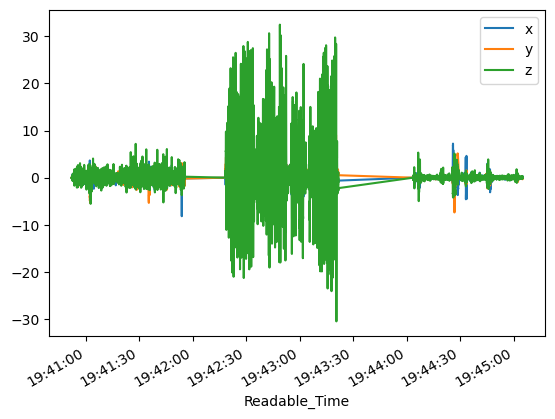

In [123]:
training.plot(x = "Readable_Time", y= ["x", "y", "z"])

<h1>Der heiße Scheiß! Timeseries Classification for Mobility!</h1>

<h2>Data Preprocessing</h2>

Das Vorgehen / meine Idee dazu, wie der Kram überhaupt funktionieren soll, hier fix dokumentiert:

Wir suchen uns aus den gesammelten Daten ~3 Sensoren aus, die wir für sinnvoll für die Klassifizierung halten (ich denke an Accelerometer, vom GPS das Speed Attribut und vlt noch der Lichtsensor). 

Wir reduzieren die Sensordaten einer Aufnahme dann auf diese Daten. Die Granularität der Daten ist egal, sie müssen auch nicht aufeinader gejoint werden. 

Für diese Daten werden Kennzahlen ausgerechnet, die Kennzahlen werden dann in einem Dataframe gespeichert und für das ML Modell zum trainieren verwendet.

<h3>Setup</h3>

Das steht am Anfang des Notebooks auch schon, aber ich hab keinen Bock, immer hoch und runter zu scrollen, daher importier' ich das hier nochmal

In [1]:
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import tsfresh
import pickle
import math
import os

In [2]:
sensors = ["Accelerometer","Location","Orientation"]
path = r"C:\Users\ReneJ\Desktop\Data"

<h3>Datenmassenvorverarbeitungsmethoden</h3>

Mit den beiden unten stehenden Methoden können wir super schnell und automatisiert Daten einlesen und umformatieren. Die Methoden machen beide da gleiche, die eine ist für CSVs, die andere für JSONs.

*transform_data_csv()* bekommt als Parameter einaml *folder* und *action*. *folder* ist der Dateipfad zum Ordner, in dem die ganzen Sensordaten im CSV Format liegen. Die Daten werden über den Dateipfad path(siehe oben) + folder (Parameter) + sensor (Einträge aus der *sensors* List, auch hier, siehe oben) gelsesen.

Bei *transform_data_json* gibt es den Parameter *folder* nicht, sondern den Parameter *subpath*. Im der JSON Datei sind alle Sensordaten enthalten und werden nicht gesplittet, anders als bei den CSVs, da ist jede CSV ein Sensor. Daher kann man hier einfach direkt den restlichen Dateipfad übergeben. Die JSON Dateien werden dann über den Pfad path (siehe oben) + subpath (der Parameter) eingelesen.

**Beide** Methoden haben den Parameter *action*. Dieser gibt an, zu welcher Aktivität die eingelesenen Daten gehören (Auto, Fahrrad, Laufen, Bus, Ubahn, Stehen)


Beide Methoden geben am Ende ein **Dictionary** zurück. Das Dictionary ist bei beiden Methoden im selben Format. Dieses Dictionary weist den Sensornamen (z.B. "Accelerometer") einen Dataframe zu. Außerdem speichert das Dictionary die Aktivität noch dazu. Jeder Dataframe hat eine eindeutige ID, diese hat den selben Wert wie *folder* oder *subpath*


In [3]:
def transform_data_csv(folder, action = ""):  
    datasets = {} #Ein Dictionary
    datasets["activity"] = action #Die Transportart wird im Dictionary gespeichert
    for sensor in sensors:
        #Dataframe wird eingelesen
        df = pd.read_csv(path + folder + "\\" + sensor + ".csv")

        #Zeittransformation
        #df["time"] = pd.to_datetime(df['time'], unit = 'ns')
        #df["Readable_Time"] = df["time"]
        #for i in range(0,len(df["time"])):
        #    df["Readable_Time"][i] = df["time"][i].to_pydatetime()
        df = df.drop(columns=["time"])
        df = df.dropna(axis = 1)

        #Datenschutz. Falls Location ein Sensor ist, wird davon nur die Speed verwendet
        if(sensor == "Location"):
            df = df.drop(columns= df.columns.difference(["speed", "Readable_Time", "seconds_elapsed"]))

        #df["activity"] = action #Darf hier nicht gesetzt werden, ist aber im Dicitonary vermerkt
        df["ID"] = folder
        
        #Dataframe wird dem Dictionay hinzugefügt
        datasets[sensor] = df
        
    return datasets



In [4]:
def transform_data_json(subPath, action = ""):
    datasets = {} #Ein Dictionary
    datasets["activity"] = action #Die Transportart wird im Dictionary gespeichert

    df = pd.read_json(path + subPath)

    #Zeittransformation
    #df["time"] = pd.to_datetime(df['time'], unit = 'ns')
    ##df["Readable_Time"] = df["time"]
    #for i in range(0,len(df["time"])):
    #    df["Readable_Time"][i] = df["time"][i].to_pydatetime()
    df = df.drop(columns=["time"])
    
    for sensor in sensors:
        temp = df.loc[df["sensor"] == sensor]
        temp = temp.dropna(axis = 1)
        temp = temp.drop(columns=["sensor"])
        #Datenschutz. Falls Location ein Sensor ist, wird davon nur die Speed verwendet
        if(sensor == "Location"):
            temp = temp.drop(columns= temp.columns.difference(["speed", "Readable_Time", "seconds_elapsed"]))

        #temp["activity"] = action #Darf hier nicht gesetzt werden, ist aber im Dicitonary vermerkt
        temp["ID"] = subPath
            
        #Dataframe wird dem Dictionary hinzugefügt
        datasets[sensor] = temp

    return datasets


<h3>Datentransformation mittels tsfresh</h3>
Die Codezeile

features = tsfresh.extract_features(Dictionary[Key zum Dataframe], column_id = "ID",column_sort='Readable_Time', 
                                       default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())

oder auch 

features = tsfresh.extract_features(Dictionary[Key zum Dataframe], column_id = "ID",column_sort='Readable_Time')

ist super duper wichtig. Mit ihr wird ein Dataframe zu einem neuen Dataframe umgewandelt. Der neue Dataframe besteht aus einer Zeile und n Spalten, wobei jede Spalte eine Metrik ist, die über die Ursprungsdataframe berechnet wurde. Das ist das Format, über das unser ML Modell trainieren wird. Dem neuen Dataframe muss man noch eine Spalte hinzufügen, in der steht, zu welcher Aktivität die Zeile gehört

___________________________________________________________________


Anyways, was zum Code hier unter mir: 

Die Daten, die wir gesammelt haben, sind in Dateien gespeichert (logischerweise, es sei denn, einer von euch hat auf Papier die ganze Zeit mitgeschrieben). Diese Dateien haben alle Dateipfade (vgl Eintrag zu den beiden Transformationsmethoden). Für jede Kategorie von Daten gibt es hier unter mir ein Dictionary, dieses Dictionary enthält einen string namens *folder_name* und einen Bezeichner als string namens *activity*. *activity* ist selbsterklärend. In *data* stehen die Dateipfade zu den Ordnern drinnen, die von den Transformationsmethoden gebraucht werden. Da CSVs und JSONs unterschiedlich verarbeitet werden, gibt es zu jeder Aktivität zwei Dictionaries, eins für CSVs, eins für JSONs.


In [5]:
car_csvs ={
    "folder_name" : r"\1. Car_CSV",
    "activity" :"car"
    }
bike_csvs = {
    "folder_name" : r"\2. Bike_CSV",
    "activity" : "bike"
    }
walk_csvs = {
    "folder_name" : r"\3. Walk_CSV",
    "activity" : "walk"
    }
bus_csvs = {
    "folder_name" : "",
    "activity" : "bus"
    }
subway_csvs = {
    "folder_name" : r"\4. Subway_CSV",
    "activity" : "subway"
    }  
idle_csvs = {
    "folder_name" : r"\5. Idle_CSV",
    "activity" : "idle"
    }
#-----------------------------
#"\JSON\.json"
car_jsons= {
    "folder_name" : r"\1. Car_JSON",
    "activity" : "car"
    }
bike_jsons = {
    "folder_name" : r"\2. Bike_JSON",
    "activity" : "bike"
    }
walk_jsons = {
    "folder_name" : r"\3. Walk_JSON",
    "activity" : "walk"
    }
bus_jsons = {
    "folder_name" : "",
    "activity" : "bus"
    }
subway_jsons = {
    "folder_name" : r"\4. Subway_JSON",
    "activity" : "subway"
    }
idle_jsons = {
    "folder_name" : r"\5. Idle_JSON",
    "activity" : "idle"
    }
roller_jsons = {
    "folder_name" : r"\6. Roller_JSON",
    "activity" : "roller"
}

data_csv = [car_csvs, bike_csvs, walk_csvs, subway_csvs, idle_csvs]
data_json = [car_jsons, bike_jsons, walk_jsons, subway_jsons, idle_jsons, roller_jsons]

<h3>Schritt 1</h3>

Alle Daten aus den beiden Listen voller Dictionaries werden mit den Methoden *transform_data_csv()* und *transform_data_json()* zu Dictionaries transformiert (siehe Beschreibung der Methoden). Diese Dicts werden in der Liste *transformed_data_list* gespeichert

In [17]:
transformed_data_list = []

for dict in data_csv:
    for folder in os.listdir(path + dict["folder_name"]):
        transformed_data_list.append(transform_data_csv(dict["folder_name"] + "\\" + folder, dict["activity"]))
for dict in data_json:
    for file in os.listdir(path + dict["folder_name"]):
        print(path + dict["folder_name"] + ": "+ file) 
        transformed_data_list.append(transform_data_json(dict["folder_name"] + "\\" + file, dict["activity"]))

C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-11_09-59-01.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-13_16-58-52.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-13_17-28-05.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-13_20-11-51.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-13_20-42-53.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-15_18-39-29.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Auto-2023-05-15_18-45-54.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-04_08-53-14.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-04_15-25-40.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-04_15-47-22.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-05_08-45-52.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-05_09-03-37.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-09_15-43-40.json
C:\Users\ReneJ\Desktop\Data\1. Car_JSON: Car-2023-05-09_15-57-18.json
C:\Users\Rene

<h3>Schitt 1.5</h3>

Die Daten liegen als eine Liste von Dictionaries vor, nun müssen die Daten noch aufgeteilt werden, damit der Datenbestand für das Training des ML Modells groß genug ist

In [19]:
length_of_time_series = 3

In [18]:
print(len(transformed_data_list))
print("______________________________________")
#(split_assist(transformed_data_list[0]["Accelerometer"], 4))
transformed_data_list

77
______________________________________


[{'activity': 'car',
  'Accelerometer':        seconds_elapsed         z         y         x  \
  0             0.120579  0.187233 -0.230438 -0.981605   
  1             0.130580  0.187155 -0.230365 -0.981626   
  2             0.140579  0.186420 -0.229663 -0.981994   
  3             0.150580  0.186162 -0.229411 -0.982192   
  4             0.160579  0.187061 -0.230272 -0.981698   
  ...                ...       ...       ...       ...   
  45394       454.055688 -0.100753 -0.060401  0.011753   
  45395       454.065687 -0.113615 -0.140901  0.073573   
  45396       454.075686 -0.024446 -0.170122  0.045379   
  45397       454.085684 -0.020646 -0.116217  0.037940   
  45398       454.095683 -0.026585 -0.114792  0.040215   
  
                                           ID  
  0      \1. Car_CSV\Auto-2023-05-14_15-05-18  
  1      \1. Car_CSV\Auto-2023-05-14_15-05-18  
  2      \1. Car_CSV\Auto-2023-05-14_15-05-18  
  3      \1. Car_CSV\Auto-2023-05-14_15-05-18  
  4      \1. Car_CSV\Au

In [20]:
splitted_list = []

for dict in transformed_data_list:
    amount_of_splits = 999999999999
    print(dict["Accelerometer"].iloc[-1]["ID"])
    #print(dict)
    for sensor in sensors:
        temp_aos = math.floor(dict[sensor]["seconds_elapsed"].iloc[-1]/(60 * length_of_time_series))
        if temp_aos < amount_of_splits:
            amount_of_splits = temp_aos
    print(amount_of_splits)
    if amount_of_splits == 999999999999 or amount_of_splits <= 1: #case 1: Something went wrong, we don't split. Case 2: The Timeseries is not long enough to be splited
        #Wenn der Datensatz zu kurz zum splitten ist, wird er nicht gesplittet, stattdessen wird er einfach als ganzes in die splitted_list gelegt
        splitted_list.append(dict)
    
    else:
        split_dict = {} #Dieses dictionary wird jedem Sensor eine Liste von aufgesplitteten DFs zuweisen
        split_dict["activity"] = dict["activity"]
        for sensor in sensors:
            splitted_dict_entry = np.array_split(dict[sensor], amount_of_splits) #Das ist jetzt ne Liste mit aufgeteilten Dataframes
            print(len(splitted_dict_entry))
            id_suffix = 0
            for df in splitted_dict_entry:
                df["ID"] = df["ID"] + "_" + str(id_suffix)
                id_suffix += 1
                
            split_dict[sensor] = splitted_dict_entry
        
        for i in range(0, amount_of_splits):
            sub_dict = {}
            sub_dict["activity"] = dict["activity"]
            for sensor in sensors:
                sub_dict[sensor] = split_dict[sensor][i]
            splitted_list.append(sub_dict)

     
splitted_list
                       
#x = transformed_data_list[0]["Accelerometer"]["seconds_elapsed"][len(transformed_data_list[0]["Accelerometer"]["seconds_elapsed"]) -1] /180
#y = transformed_data_list[0]["Brightness"]["seconds_elapsed"][len(transformed_data_list[0]["Brightness"]["seconds_elapsed"]) -1] /180
#math.floor(x) == math.floor(y)

#n = np.array_split(transformed_data_list[0]["Accelerometer"], x)
#i = 0
#for df in n:
#    df["ID"] = df["ID"] + "_" + str(i)
#    i += 1
#n

\1. Car_CSV\Auto-2023-05-14_15-05-18
2
2
2
2
\1. Car_CSV\Auto-2023-05-14_16-22-43
6
6
6
6
\1. Car_CSV\Car-2023-05-04_09-47-00
4
4
4
4
\1. Car_CSV\Car-2023-05-09_13-33-11
6
6
6
6
\1. Car_CSV\Car-2023-05-17_13-34-23
6
6
6
6
\2. Bike_CSV\Bike-2023-05-18_09-38-12
20
20
20
20
\3. Walk_CSV\Laufen-2023-05-14_15-29-52
17
17
17
17
\3. Walk_CSV\Walking2-2023-05-05_10-48-56
16
16
16
16
\4. Subway_CSV\Subway-2023-05-17_16-12-11
2
2
2
2
\5. Idle_CSV\Idle-2023-05-11_12-18-55
19
19
19
19
\5. Idle_CSV\Idle-2023-05-11_14-49-01
9
9
9
9
\5. Idle_CSV\Idle-2023-05-15_20-42-03
22
22
22
22
\5. Idle_CSV\Idle-2023-05-16_13-04-08
16
16
16
16
\5. Idle_CSV\Idle_-2023-05-15_14-52-43
57
57
57
57
\1. Car_JSON\Auto-2023-05-11_09-59-01.json
1
\1. Car_JSON\Auto-2023-05-13_16-58-52.json
3
3
3
3
\1. Car_JSON\Auto-2023-05-13_17-28-05.json
5
5
5
5
\1. Car_JSON\Auto-2023-05-13_20-11-51.json
2
2
2
2
\1. Car_JSON\Auto-2023-05-13_20-42-53.json
4
4
4
4
\1. Car_JSON\Auto-2023-05-15_18-39-29.json
1
\1. Car_JSON\Auto-2023-05-15_18

[{'activity': 'car',
  'Accelerometer':        seconds_elapsed         z         y         x  \
  0             0.120579  0.187233 -0.230438 -0.981605   
  1             0.130580  0.187155 -0.230365 -0.981626   
  2             0.140579  0.186420 -0.229663 -0.981994   
  3             0.150580  0.186162 -0.229411 -0.982192   
  4             0.160579  0.187061 -0.230272 -0.981698   
  ...                ...       ...       ...       ...   
  22695       227.066339 -0.050210 -0.240214 -0.166415   
  22696       227.076338 -0.136645 -0.211406 -0.074958   
  22697       227.086337 -0.211671 -0.142562  0.500646   
  22698       227.096336  0.119839  0.096554 -0.158943   
  22699       227.106334  0.176266  0.175957  0.889776   
  
                                             ID  
  0      \1. Car_CSV\Auto-2023-05-14_15-05-18_0  
  1      \1. Car_CSV\Auto-2023-05-14_15-05-18_0  
  2      \1. Car_CSV\Auto-2023-05-14_15-05-18_0  
  3      \1. Car_CSV\Auto-2023-05-14_15-05-18_0  
  4      \1. 

<h3>Schritt 2</h3>

Die Daten werden mit tsfresh zu Kennzahlen umgewandelt. Für jedes Dictionary in der *transformed_data_list* wird für jeden Sensor aus der Sensor-Liste der in dem Dict gespeicherte Dataframe zu Kennzahlen mit tsfresh umgewandelt. Denn jedes dictionary hat für jeden Sensor aus der List einen Dataframe gespeichert. Die Kennzahlen werden als ein neuer Dataframe gespeichert, diesem Dataframe wird noch das Attribut "Activity" hinzugefügt, dieses speichert die Fortbewegungsart. Der Wert dafür kommt aus dem Dictionary.

Jeder Kennzahlendataframe hat genau eine Reihe.

In der Liste *final_form_data_list* wird jeder einzeilige Kennzahlen-Dataframe zusammen mit der Sensorart des Kennzahlen-Dataframes als ein Dictionary gespeichert.

In [21]:
final_form_data_list = []

for dict in splitted_list:
    for sensor in sensors:
        dict[sensor] = dict[sensor].drop(columns=["seconds_elapsed"])

        temp = tsfresh.extract_features(dict[sensor], column_id = "ID",
                                        default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters())
        temp["activity"] = dict["activity"]
        #temp["ID"] = dict[sensor]["ID"]
        final_form_data_list.append({"data" : temp, "sensor" : sensor})

Feature Extraction: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


In [22]:
final_form_data_list[0]


{'data':                                         z__sum_values  z__median  z__mean  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0     480.796976   0.010648  0.02118   
 
                                         z__length  z__standard_deviation  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0    22700.0               0.379395   
 
                                         z__variance  z__root_mean_square  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0     0.143941             0.379986   
 
                                         z__maximum  z__absolute_maximum  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0   18.371723            18.371723   
 
                                         z__minimum  ...  x__median   x__mean  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0   -6.579088  ...   0.014165  0.018482   
 
                                         x__length  x__standard_deviation  \
 \1. Car_CSV\Auto-2023-05-14_15-05-18_0    22700.0               0.402896   
 
                                         x__vari

<h3>Schritt 3 </h3>

Nun werden die ganzen Dataframes mit den gleichen Sensoren zu jeweils einem kombiniert. Also wenn ich am Ende von Schritt 2 drei Accelerometer dfs, drei Location dfs und drei Orientation dfs hatte, hab ich am Ende von Schritt drei einen Accelerometer df, einen Location df und einen Orientation df mit jeweils drei Zeilen.

Diese Dataframes werden alle in der Liste *very_final_form_data_list* gespeichert. Ich weiß, meine Listennamen sind einfach top tier xD.

In [23]:
very_final_form_data_list = []

for sensor in sensors:
    temp_list = []
    for dict in final_form_data_list:
        if str(dict["sensor"]) == str(sensor):
            temp_list.append(dict["data"])
    concat_temp = pd.concat(temp_list)
    very_final_form_data_list.append(concat_temp)

<h3>Schritt 4</h3>

Der letzte Schritt zur Datentransformation und auch der trivialste. Die Dataframes aus der Liste *very_final_form_data_list* werden konkateniert. Da der Index von allen Dataframes hier die eindeutige ID ist, sollte man die einfach so ohne Probleme aneinanderlegen können, ohne großartige Join-Logik. 

Die Spalte "activity" ist nun n Mal vorhanden, die Duplikatspalten werden dann entfernt.

Sämtliche Daten aus den 12 Dictionaries von vor Schritt 1 sind nun transformiert in dem Dataframe *df_final* gespeichert.

In [24]:
#Join all the Dataframes to one Dataframe
df_final = pd.concat(very_final_form_data_list, axis = 1)

#Drop duplicate "activity" Columns
d = df_final.T.drop_duplicates().T
d["activity"]
df_final = df_final.drop(columns=["activity"])
df_final["activity"] = d["activity"]

#Final Dataframe with all the transformed data
df_final

,z__sum_values,z__median,z__mean,z__length,z__standard_deviation,z__variance,z__root_mean_square,z__maximum,z__absolute_maximum,z__minimum,...,yaw__median,yaw__mean,yaw__length,yaw__standard_deviation,yaw__variance,yaw__root_mean_square,yaw__maximum,yaw__absolute_maximum,yaw__minimum,activity
\1. Car_CSV\Auto-2023-05-14_15-05-18_0,480.796976,0.010648,0.021180,22700.0,0.379395,0.143941,0.379986,18.371723,18.371723,-6.579088,...,0.318228,0.501856,22700.0,0.920331,0.847010,1.048270,2.164712,2.164712,-1.361076,car
\1. Car_CSV\Auto-2023-05-14_15-05-18_1,523.297570,0.010512,0.023054,22699.0,0.423658,0.179486,0.424285,8.211536,8.211536,-6.956941,...,1.555747,1.071482,22699.0,1.509736,2.279301,1.851317,3.141388,3.141529,-3.141529,car
\1. Car_CSV\Auto-2023-05-14_16-22-43_0,422.667118,0.021073,0.021657,19516.0,0.425147,0.180750,0.425699,12.206304,12.206304,-5.100147,...,-0.001781,-0.125939,19516.0,0.928980,0.863004,0.937478,3.141327,3.141327,-3.140354,car
\1. Car_CSV\Auto-2023-05-14_16-22-43_1,28.141838,0.005733,0.001442,19516.0,0.335012,0.112233,0.335015,1.551357,1.703092,-1.703092,...,-0.321212,-0.300522,19516.0,0.197153,0.038869,0.359420,0.310741,0.624272,-0.624272,car
\1. Car_CSV\Auto-2023-05-14_16-22-43_2,524.267180,0.027544,0.026863,19516.0,0.346725,0.120218,0.347764,2.292346,2.292346,-2.230829,...,1.121115,0.614415,19516.0,1.733466,3.004903,1.839133,3.140842,3.141392,-3.141392,car
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
\6. Roller_JSON\Roller3-2023-05-03_20-12-44.json_1,860.604343,0.013891,0.080190,10732.0,0.645662,0.416880,0.650623,5.586761,5.586761,-3.360151,...,0.264956,0.820341,10732.0,0.925426,0.856413,1.236678,2.211001,2.211001,-0.407273,roller
\6. Roller_JSON\Roller3-2023-05-03_20-12-44.json_2,705.862641,-0.010224,0.065778,10731.0,1.643794,2.702058,1.645109,12.521783,12.521783,-12.235073,...,0.991834,0.853478,10731.0,1.700273,2.890928,1.902460,3.141274,3.141429,-3.141429,roller
\6. Roller_JSON\Roller3-2023-05-03_20-12-44.json_3,202.746492,0.000164,0.018894,10731.0,1.164035,1.354978,1.164189,16.666538,28.471104,-28.471104,...,1.787794,1.583386,10731.0,1.449810,2.101949,2.146872,3.139839,3.140412,-3.140412,roller
\6. Roller_JSON\Roller3-2023-05-03_20-12-44.json_4,1480.606835,0.037856,0.137975,10731.0,2.154118,4.640224,2.158532,21.367308,21.367308,-15.343895,...,-0.250949,-0.227500,10731.0,1.744986,3.044977,1.759754,3.141453,3.141453,-3.137894,roller


In [25]:
print("Car: " + str(len(df_final.loc[df_final["activity"] == "car"])))
print("Walk: " + str(len(df_final.loc[df_final["activity"] == "walk"])))
print("Bike: " + str(len(df_final.loc[df_final["activity"] == "bike"])))
print("Subway: " + str(len(df_final.loc[df_final["activity"] == "subway"])))
print("Idle: " + str(len(df_final.loc[df_final["activity"] == "idle"])))
print("Roller: " + str(len(df_final.loc[df_final["activity"] == "roller"])))

Car: 79
Walk: 72
Bike: 28
Subway: 19
Idle: 123
Roller: 58


In [27]:
df_final.to_csv(path + "\\"+ "test.csv")

<h2>Machine Learning! Juhey</h2>

Ab hier geht der Machinelearning Teil los, was hier geschehen muss ist, ein Modell mit den Daten, die wir transformiert haben, zu trainieren. Dafür brauchen wir eine Unterscheidung zwischen Trainings- Test- und Validierungsdaten. 

**ToDo**: Hyperparameteroptimization anschauen

<h3>Machine Learning Importe</h3>

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
df_final = pd.read_csv(path + "\\" + "test.csv")
ml_eval = []
len(df_final)

379

In [5]:
y = df_final["activity"]
x = df_final.drop(columns= ["activity", "Unnamed: 0"])
#x = df_final.drop(columns= "activity")

xTrain, xTest, yTrain, yTest =  train_test_split(x,y, test_size = 0.3, random_state = 5)

In [6]:
print("Car: " + str(len(yTest.loc[df_final["activity"] == "car"])))
print("Walk: " + str(len(yTest.loc[df_final["activity"] == "walk"])))
print("Bike: " + str(len(yTest.loc[df_final["activity"] == "bike"])))
print("Subway: " + str(len(yTest.loc[df_final["activity"] == "subway"])))
print("Idle: " + str(len(yTest.loc[df_final["activity"] == "idle"])))
print("Roller: " + str(len(yTest.loc[df_final["activity"] == "roller"])))

Car: 24
Walk: 25
Bike: 6
Subway: 7
Idle: 35
Roller: 17


<h3>Support Vector Classification</h3>

<h4>Hyperparameter Tuning</h4>

In [7]:
gs = GridSearchCV(
    sk.svm.SVC(),
    param_grid={"kernel" : ["linear", "rbf", "poly", "sigmoid"], "C" : [0.1, 1, 10]},
    scoring= {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)},
    refit= "AUC",
    n_jobs= 16,
    return_train_score=True
)

gs.fit(xTrain, yTrain)
results = gs.cv_results_

results["params"][np.argmax(results["mean_test_Accuracy"])]

hpoSVC = sk.svm.SVC(C= results["params"][np.argmax(results["mean_test_Accuracy"])]["C"], kernel= results["params"][np.argmax(results["mean_test_Accuracy"])]["kernel"]) 
hpoSVC.fit(xTrain, yTrain)

ml_eval.append({"Model Name" : "HPO Support Vector Classifier", "Model" : hpoSVC})

c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


<h4>Default Settings</h4>

In [8]:
Support_Vector_Classifier = sk.svm.SVC()
Support_Vector_Classifier.fit(xTrain, yTrain)

ml_eval.append({"Model Name" : "Support Vector Classifier", "Model" : Support_Vector_Classifier})


<h3>Naive Bayes Classification</h3>

In [9]:
GaussianNaiveBayes = GaussianNB()
GaussianNaiveBayes.fit(xTrain, yTrain)

ml_eval.append({"Model Name" : "Naive Bayes Classification", "Model" : GaussianNaiveBayes})

<h3>K Nearest Neighbour</h3>

<h4>Hyperparameter Tuning</h4>

In [10]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid= {"n_neighbors" : [2,5,7,10], "weights" : ["uniform", "distance"]},
    scoring= {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)},
    refit= "AUC",
    n_jobs= 16,
    return_train_score=True
)
gs.fit(xTrain, yTrain)
results = gs.cv_results_

print(results["params"][np.argmax(results["mean_test_Accuracy"])])

hpoKNN = KNeighborsClassifier(n_neighbors= results["params"][np.argmax(results["mean_test_Accuracy"])]["n_neighbors"], 
                              weights= results["params"][np.argmax(results["mean_test_Accuracy"])]["weights"]) 
hpoKNN.fit(xTrain, yTrain)
ml_eval.append({"Model Name" : "HPO K-Nearest Neighbour", "Model" : hpoKNN})


{'n_neighbors': 2, 'weights': 'distance'}


c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


<h4>Default Settings</h4>

In [11]:
knn = KNeighborsClassifier()
knn.fit(xTrain, yTrain)

ml_eval.append({"Model Name" : "K Nearest Neighbour", "Model" : knn})


<h3>Random Forest</h3>

<h4>Hyperparameter Tuning</h4>

In [12]:
gs = GridSearchCV(
    RandomForestClassifier(),
    param_grid= {"max_features" : ["sqrt", "log2"], "n_estimators" : [50, 75, 100, 150, 200], "min_samples_split" : range(2,403,20)},
    scoring= {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)},
    refit= "AUC",
    n_jobs= 16,
    return_train_score=True
)
gs.fit(xTrain, yTrain)
results = gs.cv_results_

print(results["params"][np.argmax(results["mean_test_Accuracy"])])

hpoRNF= RandomForestClassifier(max_features= results["params"][np.argmax(results["mean_test_Accuracy"])]["max_features"], 
                              n_estimators= results["params"][np.argmax(results["mean_test_Accuracy"])]["n_estimators"],
                              min_samples_split = results["params"][np.argmax(results["mean_test_Accuracy"])]["min_samples_split"]) 
hpoRNF.fit(xTrain, yTrain)
ml_eval.append({"Model Name" : "HPO Random Forest", "Model" : hpoRNF})

c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan

{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}


<h4>Default Settings</h4>

In [13]:
rnf = RandomForestClassifier()
rnf.fit(xTrain, yTrain)

ml_eval.append({"Model Name" : "Random Forest", "Model" : rnf})

<h3>Long Short Term Memory</h3>

<h3>Evaluation</h3>

c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\

--- HPO Support Vector Classifier ---
Accuarcy score: 78.0701754385965
Recall score: 68.68464052287581
Precision score: 60.916305916305916
Confusion Report: HPO Support Vector Classifier
              precision    recall  f1-score   support

        bike       0.55      1.00      0.71         6
         car       0.63      0.79      0.70        24
        idle       1.00      1.00      1.00        35
      roller       0.64      0.53      0.58        17
      subway       0.00      0.00      0.00         7
        walk       0.83      0.80      0.82        25

    accuracy                           0.78       114
   macro avg       0.61      0.69      0.63       114
weighted avg       0.75      0.78      0.76       114



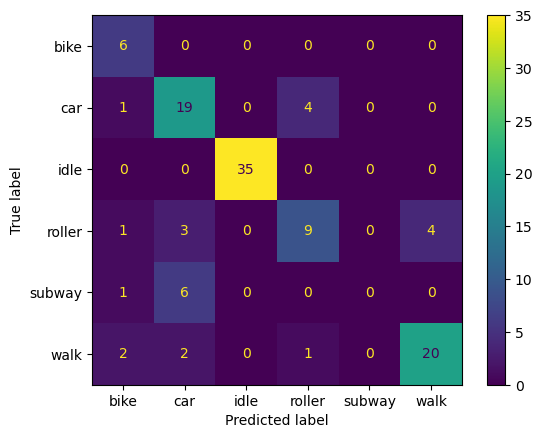

----------------------------------------
--- Support Vector Classifier ---
Accuarcy score: 69.2982456140351
Recall score: 54.85224089635855
Precision score: 54.7602495543672
Confusion Report: Support Vector Classifier
              precision    recall  f1-score   support

        bike       0.40      0.33      0.36         6
         car       0.59      0.54      0.57        24
        idle       0.68      0.97      0.80        35
      roller       0.76      0.76      0.76        17
      subway       0.00      0.00      0.00         7
        walk       0.85      0.68      0.76        25

    accuracy                           0.69       114
   macro avg       0.55      0.55      0.54       114
weighted avg       0.65      0.69      0.66       114



c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\envs\ML4B\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ReneJ\anaconda3\

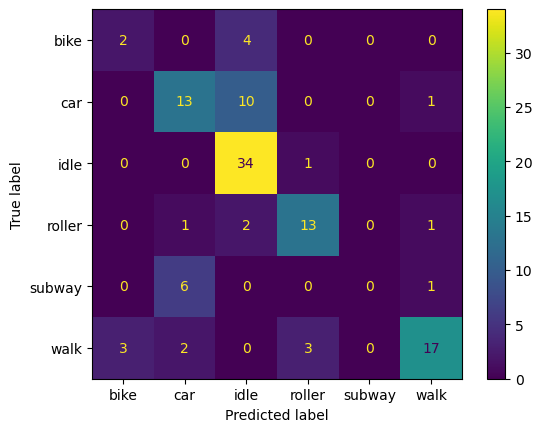

----------------------------------------
--- Naive Bayes Classification ---
Accuarcy score: 94.73684210526315
Recall score: 93.5749299719888
Precision score: 95.3553724227211
Confusion Report: Naive Bayes Classification
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         6
         car       0.91      0.88      0.89        24
        idle       1.00      1.00      1.00        35
      roller       0.88      0.88      0.88        17
      subway       1.00      0.86      0.92         7
        walk       0.93      1.00      0.96        25

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



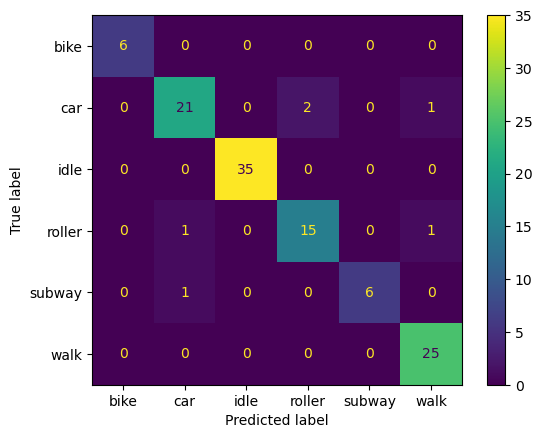

----------------------------------------
--- HPO K-Nearest Neighbour ---
Accuarcy score: 85.96491228070175
Recall score: 79.6141456582633
Precision score: 81.80952380952382
Confusion Report: HPO K-Nearest Neighbour
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         6
         car       0.70      0.88      0.78        24
        idle       1.00      0.97      0.99        35
      roller       0.93      0.76      0.84        17
      subway       0.40      0.29      0.33         7
        walk       0.88      0.88      0.88        25

    accuracy                           0.86       114
   macro avg       0.82      0.80      0.80       114
weighted avg       0.86      0.86      0.86       114



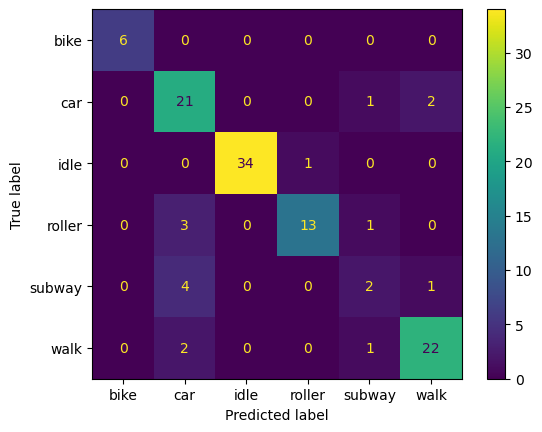

----------------------------------------
--- K Nearest Neighbour ---
Accuarcy score: 79.82456140350878
Recall score: 73.36811391223156
Precision score: 73.95577395577396
Confusion Report: K Nearest Neighbour
              precision    recall  f1-score   support

        bike       0.55      1.00      0.71         6
         car       0.63      0.79      0.70        24
        idle       0.89      0.94      0.92        35
      roller       0.87      0.76      0.81        17
      subway       0.50      0.14      0.22         7
        walk       1.00      0.76      0.86        25

    accuracy                           0.80       114
   macro avg       0.74      0.73      0.70       114
weighted avg       0.82      0.80      0.79       114



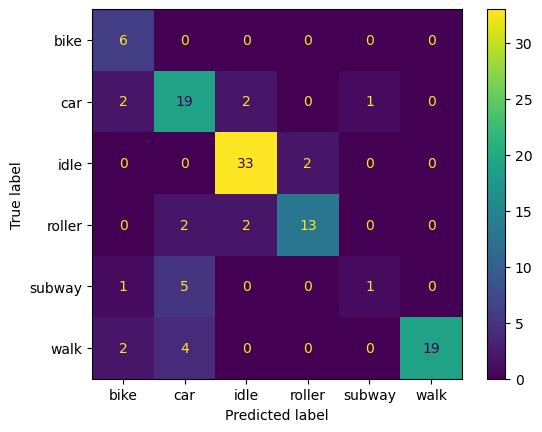

----------------------------------------
--- HPO Random Forest ---
Accuarcy score: 95.6140350877193
Recall score: 93.98342670401493
Precision score: 93.10897435897436
Confusion Report: HPO Random Forest
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         6
         car       0.96      0.96      0.96        24
        idle       1.00      1.00      1.00        35
      roller       1.00      0.82      0.90        17
      subway       0.67      0.86      0.75         7
        walk       0.96      1.00      0.98        25

    accuracy                           0.96       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.96      0.96      0.96       114



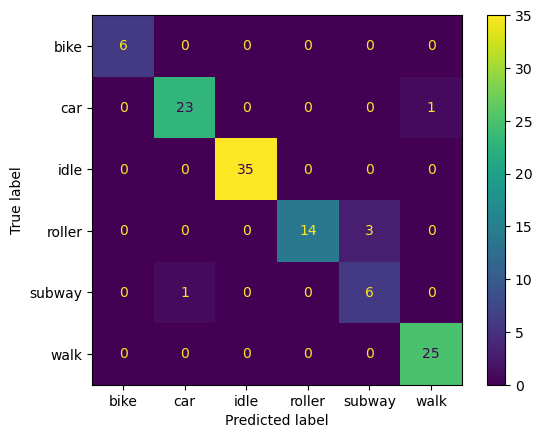

----------------------------------------
--- Random Forest ---
Accuarcy score: 95.6140350877193
Recall score: 93.98342670401493
Precision score: 93.90432098765432
Confusion Report: Random Forest
              precision    recall  f1-score   support

        bike       1.00      1.00      1.00         6
         car       0.96      0.96      0.96        24
        idle       1.00      1.00      1.00        35
      roller       1.00      0.82      0.90        17
      subway       0.75      0.86      0.80         7
        walk       0.93      1.00      0.96        25

    accuracy                           0.96       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.96      0.96      0.96       114



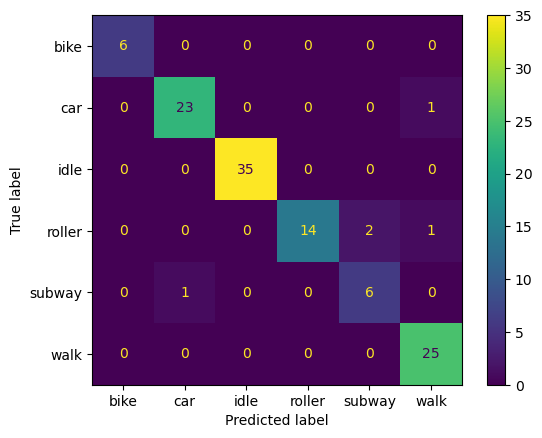

----------------------------------------


In [30]:
for entry in ml_eval:

    yPred = entry["Model"].predict(xTest)

    acc = accuracy_score(yTest, yPred) * 100
    cr = classification_report(yTest, yPred)
    rc = recall_score(yTest, yPred, average="macro") * 100
    pc = precision_score(yTest, yPred, average="macro") * 100
    cm = confusion_matrix(yTest, yPred)

    print("--- " + entry["Model Name"] + " ---")

    print("Accuarcy score: "+ str(acc))
    print("Recall score: " + str(rc))
    print("Precision score: " + str(pc))

    print("Confusion Report: " + entry["Model Name"])   
    print(cr)

    disp = ConfusionMatrixDisplay(cm, display_labels= entry["Model"].classes_)
    disp.plot()
    plt.show()

    print("----------------------------------------")

    entry["Classification Report"] = cr
    entry["Accuracy Score"] = acc